In [1]:
import time
from pathlib import Path

import fastddm as fddm
import fastddm.window as window
import fastddm.mask as mask
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

%matplotlib inline

In [2]:
# read image files
impath = Path("../tests/test-imgs/confocal/")
images = fddm.read_images([p for p in sorted(impath.glob("*.tif"))])
images.shape

(1024, 256, 256)

In [3]:
# set pixel size & difference between 2 consecutive images
## see readme.txt in tests/test-imgs/
pixel_size = 0.123  # µm/px
dt = 43e-3  # s 

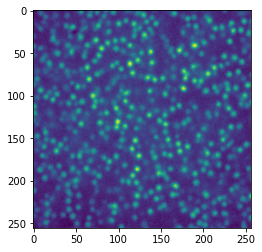

In [4]:
# check a sample image
test_im = 1
plt.imshow(images[test_im])

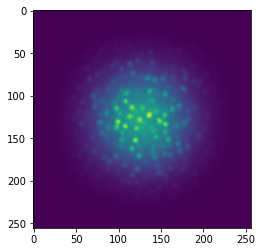

In [5]:
# in case you'd like to apply a standard windowing function to the images, you can do it now:
bh_window = window.blackman_harris(images.shape)

plt.imshow(bh_window * images[test_im])

# uncomment the line below to apply the window to all images
# images = bh_window * images

In [6]:
# setup lags
lags = np.arange(1, len(images)//2)  # lag times in frames up to 50% of the overall movie length
actual_time = lags * dt

### C++ backend

In [7]:
start = time.perf_counter()
structure_function = fddm.ddm(images, lags, core="cpp", mode="fft")

print(f"Duration: [{time.perf_counter()-start:.2f}] seconds")

Duration: [2.09] seconds


In [8]:
# set pixel_size and dt
structure_function.delta_t = dt
structure_function.pixel_size = pixel_size

### python backend

In [9]:
start = time.perf_counter()
structure_function_py = fddm.ddm(images, lags, core="py", mode="fft")

print(f"Duration: [{time.perf_counter()-start:.2f}] seconds")

Duration: [3.85] seconds


In [10]:
structure_function.shape

(511, 256, 129)

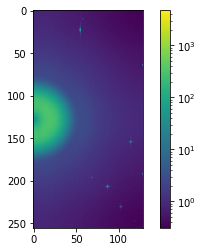

In [11]:
# investigate the structure function
plt.imshow(structure_function.data[test_im], norm=LogNorm())
plt.colorbar()

In [12]:
# now, to azimuthally average the structure function, allwhile excluding the central cross:
## first we need the mask for the central cross:
shape = structure_function.shape[1:]
cc_mask = mask.central_cross_mask(shape)

## and then hand it to the azimuthal average function
azimuthal_avg = fddm.azimuthal_average(structure_function, mask=cc_mask, bins=129, range=(0, structure_function.ky[-1]))

In [13]:
# get q vectors from azimuthal average object (since we set them initially, we don't have to compute them ourselves :) )
q = azimuthal_avg.k  # k == q

# get actual time also from azimuthal average object
actual_time = azimuthal_avg.tau  

## plotting
### for fixed $q$

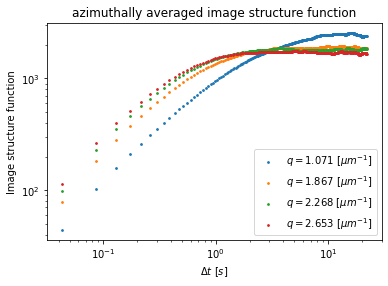

In [14]:
test_k = np.array([3, 5, 6, 7], dtype=np.int64) * 2
for tk in test_k:    
    plt.scatter(actual_time, azimuthal_avg.data[tk], marker="o", s=3, label="$q={:.3f}\ [\mu m^{{-1}}]$".format(q[tk]))
plt.xscale('log')
plt.yscale('log')
plt.xlabel("$\Delta t\ [s]$")
plt.ylabel("Image structure function")
plt.title("azimuthally averaged image structure function")
plt.legend(loc=4)

### for fixed delays

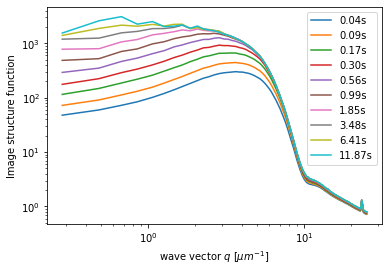

In [15]:
from fastddm.lags import logspace_int

test_dt = logspace_int(lags.max(), num=10)

for tdt in test_dt:
    plt.plot(q, azimuthal_avg.data[:, tdt], label=f"{tdt*dt:.2f}s")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("wave vector $q\ [\mu m^{-1}]$")
plt.ylabel("Image structure function")
plt.legend()

## 3d plot for fun :-) 

Text(0.5, 0.5, 'lag times')

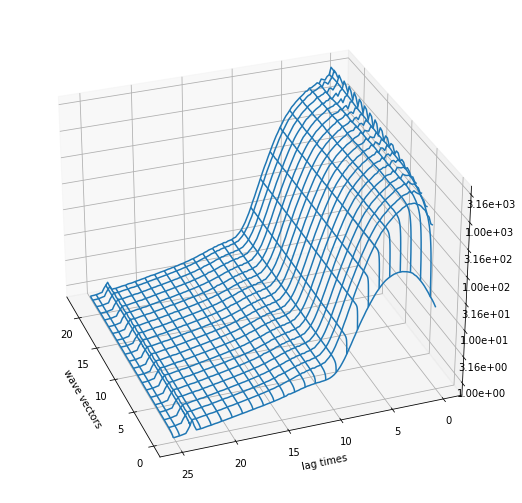

In [16]:
import matplotlib.ticker as mticker

# need to define function to format axis ticks with log values since matplotlib does not properly support logscales in 3d plots
def log_tick_formatter(val, pos=None):
    return "{:.2e}".format(10**val)

# 3d setup
fig = plt.figure(figsize=( 9, 9))
ax = fig.add_subplot(projection='3d')

# plotting
Q, DT = np.meshgrid(q, lags*dt)
ax.view_init(30, 160)
ax.plot_wireframe(DT, Q, np.log10(azimuthal_avg.data.T), rcount=20, ccount=31)

# cosmetics
ax.zaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.set_xlabel("wave vectors")
ax.set_ylabel("lag times")


## Fitting

In [17]:
from fastddm.fit import simple_structure_function, fit
simple_structure_function.set_param_hint("B", min=-np.inf, max=np.inf, value=0.0)

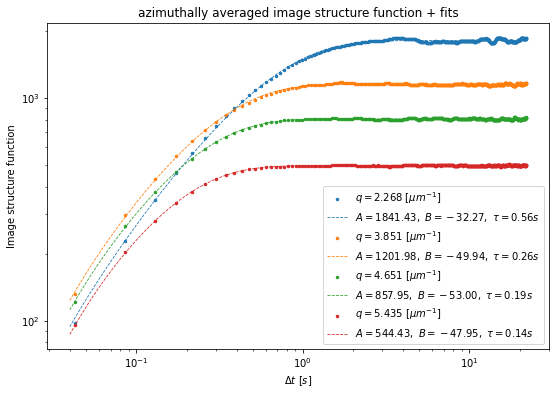

In [18]:
# plot setup
test_k = np.array([3, 5, 6, 7], dtype=np.int64) * 4  # indices
colors = ["tab:" + col for col in ["blue", "orange", "green", "red"]]
fit_time = np.logspace(-1.4, 1.1)
labelstr = r"$A = {A:.2f},\ B = {B:.2f},\ \tau = {tau:.2f}s$"
weights = 1/np.sqrt(azimuthal_avg.tau)

fig = plt.figure(figsize=(9, 6))
for tk, color in zip(test_k, colors):    
    # fit for the given fixed index/k
    result = fit(simple_structure_function, xdata=azimuthal_avg.tau, ydata=azimuthal_avg.data[tk], weights=weights)
    
    # plot original data
    plt.scatter(azimuthal_avg.tau, azimuthal_avg.data[tk], marker="o", s=6, color=color, 
                label="$q={:.3f}\ [\mu m^{{-1}}]$".format(q[tk]))
    
    # and the fit
    plt.plot(fit_time, simple_structure_function.eval(**result.best_values, dt=fit_time), 
             color=color, linestyle="--", linewidth=0.8, label=labelstr.format(**result.best_values))

# cosmetics
plt.xscale('log')
plt.yscale('log')
plt.xlabel("$\Delta t\ [s]$")
plt.ylabel("Image structure function")
plt.title("azimuthally averaged image structure function + fits")
plt.legend(loc=4)